In [1]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def normalize_none(X):
    return X

def normalize_l1(X):
    return X / np.sum(np.abs(X), axis=1, keepdims=True)

def normalize_l2(X):
    return X / np.sqrt(np.sum(X**2, axis=1, keepdims=True))

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-8
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

def generate_data(n=1000):
    X = np.random.uniform(-1, 1, (n, 2))
    X = X[np.all(X != 0, axis=1)]
    y = ((X[:, 0] * X[:, 1]) > 0).astype(int).reshape(-1, 1)
    return X, y


In [2]:
class TwoLayerNN:
    def __init__(self, activation='sigmoid', lr=0.1):
        self.lr = lr
        self.hidden_size = 4
        
        self.W1 = np.random.randn(2, self.hidden_size) * 0.1
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, 1) * 0.1
        self.b2 = np.zeros((1, 1))
        
        if activation == 'sigmoid':
            self.act = sigmoid
            self.act_deriv = sigmoid_deriv
        elif activation == 'relu':
            self.act = relu
            self.act_deriv = relu_deriv
        else:
            raise ValueError("Activation must be 'sigmoid' or 'relu'")
        
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.act(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = sigmoid(self.Z2)
        return self.A2
    
    def backward(self, X, y):
        m = X.shape[0]
        
        dZ2 = self.A2 - y
        dW2 = self.A1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.act_deriv(self.Z1)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        
    def train(self, X, y, epochs=1000):
        losses = []
        for _ in range(epochs):
            y_pred = self.forward(X)
            loss = binary_cross_entropy(y, y_pred)
            self.backward(X, y)
            losses.append(loss)
        return losses
    
    def predict(self, X):
        return (self.forward(X) > 0.5).astype(int)


In [3]:
def run_experiment(norm_func, activation, lr=0.1):
    X, y = generate_data(1000)
    X_norm = norm_func(X)
    
    model = TwoLayerNN(activation=activation, lr=lr)
    losses = model.train(X_norm, y, epochs=10000)
    acc = np.mean(model.predict(X_norm) == y)
    
    return losses, acc


Norm: None, Act: sigmoid, LR: 0.01, Final acc: 0.549, Final loss: 0.6932
Norm: None, Act: sigmoid, LR: 0.1, Final acc: 0.495, Final loss: 0.6916
Norm: None, Act: sigmoid, LR: 0.5, Final acc: 0.977, Final loss: 0.1013
Norm: None, Act: relu, LR: 0.01, Final acc: 0.908, Final loss: 0.2699
Norm: None, Act: relu, LR: 0.1, Final acc: 0.663, Final loss: 0.5762
Norm: None, Act: relu, LR: 0.5, Final acc: 1.000, Final loss: 0.0138
Norm: L1, Act: sigmoid, LR: 0.01, Final acc: 0.527, Final loss: 0.6917
Norm: L1, Act: sigmoid, LR: 0.1, Final acc: 0.523, Final loss: 0.6921
Norm: L1, Act: sigmoid, LR: 0.5, Final acc: 0.976, Final loss: 0.0720
Norm: L1, Act: relu, LR: 0.01, Final acc: 0.925, Final loss: 0.3154
Norm: L1, Act: relu, LR: 0.1, Final acc: 0.998, Final loss: 0.0202
Norm: L1, Act: relu, LR: 0.5, Final acc: 0.989, Final loss: 0.0354
Norm: L2, Act: sigmoid, LR: 0.01, Final acc: 0.505, Final loss: 0.6931
Norm: L2, Act: sigmoid, LR: 0.1, Final acc: 0.636, Final loss: 0.6912
Norm: L2, Act: sigmoi

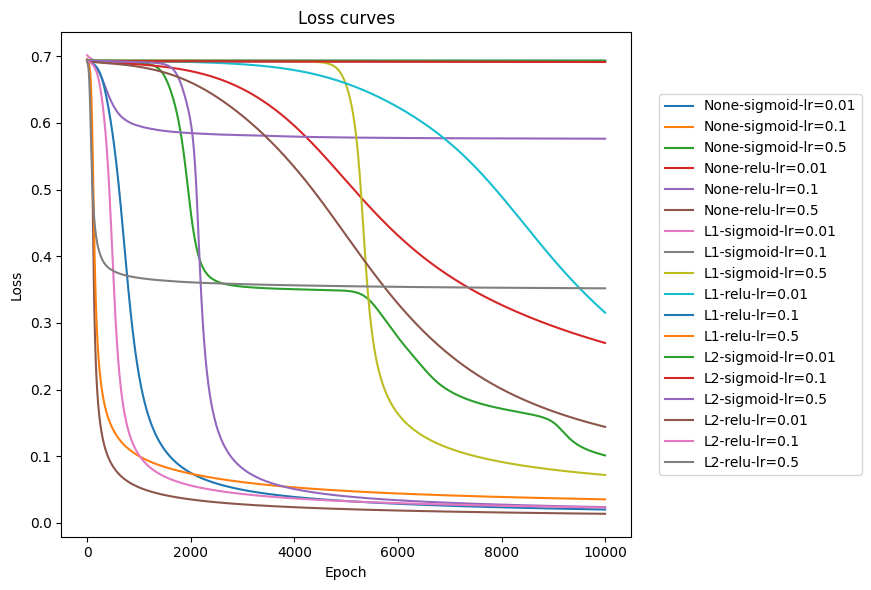

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
norms = {
    "None": normalize_none,
    "L1": normalize_l1,
    "L2": normalize_l2
}

activations = ['sigmoid', 'relu']
learning_rates = [0.01, 0.1, 0.5]

for norm_name, norm_func in norms.items():
    for act in activations:
        for lr in learning_rates:
            losses, acc = run_experiment(norm_func, act, lr)
            print(f"Norm: {norm_name}, Act: {act}, LR: {lr}, Final acc: {acc:.3f}, Final loss: {losses[-1]:.4f}")
            plt.plot(losses, label=f"{norm_name}-{act}-lr={lr}")

plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.show()


In [5]:
def evaluate_model(model, normalize_func, iterations=1000):
    correct = 0
    incorrect = 0
    
    for _ in range(iterations):
        x = np.random.uniform(-1, 1, (1, 2))
        while (x == 0).any():
            x = np.random.uniform(-1, 1, (1, 2))
        
        y_true = int(x[0, 0] * x[0, 1] > 0)
        
        x_norm = normalize_func(x)
        y_pred = model.predict(x_norm)[0, 0]
        
        if y_pred == y_true:
            correct += 1
        else:
            incorrect += 1
    
    print(f"Poprawne: {correct}")
    print(f"Błędne: {incorrect}")
    return correct, incorrect


In [6]:

X, y = generate_data(1000)
X_norm = norm_func(X)

model = TwoLayerNN(activation="relu", lr=0.5)
l = model.train(X_norm, y, epochs=10000)

In [7]:

evaluate_model(model, normalize_func=normalize_l2)

Poprawne: 999
Błędne: 1


(999, 1)

In [8]:
model.predict([0.5 , 0.3])

array([[1]])